# **LeoVegas Prediction Analysis**
- contact: Nasir Uddin nasiru32@gmail.com

This notebook demonstrates an end-to-end workflow for predicting turnover in a sportsbook dataset.

### Objectives
- Conduct data cleaning and preprocessing.
- Perform exploratory data analysis (EDA).
- Engineer features to enhance predictive power.
- Apply advanced machine learning and time-series models.
- Implement causal inference to derive actionable insights.
- Use conformal predictions for reliable uncertainty estimation.

---

### Prediction target

The prediction target for this task is: total_turn_over_EUR: The total amount of money bet by LeoVegas customers in a given time frame or event.

Why This Target?

Business Relevance:

Total turnover directly reflects customer engagement and revenue generation, making it critical for strategic planning and decision-making.

It enables forecasting for operational scaling, marketing budgets, and identifying high-turnover events.
Stakeholder Impact:

Insights into betting patterns and trends can inform targeted promotions, resource allocation, and risk management.
Predicting turnover provides actionable insights for league-specific marketing and customer segmentation.

#### Workflow to Create a Predictive Model
1. Data Understanding and Exploration
Goals:

Identify patterns, seasonality, and trends in the data.
Understand features influencing turnover, such as time, event, and league.

Actions:

Perform exploratory data analysis (EDA) to uncover trends, anomalies, and correlations.
Visualize turnover against features like hour, day_of_week, league, and event_country.

Tools:
Pandas for data manipulation.
Matplotlib and Seaborn for visualization.

2. Feature Engineering
   
Purpose:

Create informative features to improve model performance.
Examples:

Time-based features:
Extract hour, day_of_week, month, and is_weekend from bet_placement_hour.

Event-specific features:

Calculate time_to_event (difference between eventStartDate and bet_placement_hour).

Encode event_country and league using target or frequency encoding.

Rolling and lag features:

Add lag_1_turnover and rolling_3_turnover to capture temporal dependencies.


3. Modeling Approach
   
We will explore two approaches:

Time Series Models:

Use models like ARIMA/SARIMA to handle sequential dependencies and seasonal trends.
Ideal for capturing long-term seasonality in turnover.

Machine Learning Models:

Use tree-based models (e.g., LightGBM, XGBoost) for feature-rich tabular data.
Handle non-linear relationships and interactions among features.

AutoML:

Use FLAML or H2O AutoML to automate model selection and hyperparameter tuning.

4. Evaluation
5. 
Metrics:

Root Mean Squared Error (RMSE): Measures average prediction error.
Mean Absolute Error (MAE): Measures average absolute error.
R² (Coefficient of Determination): Explains how much variance is captured by the model.

Validation Strategy:

Time-based split: Ensure the training set precedes the test set to mimic real-world scenarios.

5. Uncertainty Quantification
   
Why?

- Provide stakeholders with prediction confidence intervals to aid in risk management.

How?

- Use conformal prediction via MAPIE or residual-based methods to quantify prediction uncertainty.

6. Visualization and Reporting
   
Purpose:

Present results in a stakeholder-friendly manner.

Deliverables:

Line plots of actual vs. predicted turnover.

Confidence intervals to highlight uncertainty.

Feature importance to explain model behavior.

## **1. Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dowhy import CausalModel
from mapie.regression import MapieRegressor


## **2. Load and Preprocess Data**

In [3]:
# Load dataset
data = pd.read_csv('../data/dataset.csv')
data

,bet_placement_hour,eventId,eventName,eventStartDate,event_country,league,number_of_bets,total_turn_over_EUR
0,2023-12-01 00:00:00,1020157185,Oklahoma Sooners - Arkansas-Pine Bluff Golden ...,2023-12-01 01:00:00,NCAAB,NaN,3,49.582521
1,2023-12-01 00:00:00,1020211480,LSU Tigers (W) - Virginia Tech Hokies (W),2023-12-01 02:00:00,NCAAW,NaN,4,711.310730
2,2023-12-01 00:00:00,1020030708,Miami Heat - Indiana Pacers,2023-12-01 00:42:54,NBA,NaN,136,5989.053830
3,2023-12-01 00:00:00,1020285783,Union de Mar del Plata - Tomas De Rocamora,2023-12-01 00:00:00,Argentina,TNA,133,1372.405046
4,2023-12-01 00:00:00,1020030708,Miami Heat - Indiana Pacers,2023-12-01 00:30:00,NBA,NaN,25,18843.904216
...,...,...,...,...,...,...,...,...
297282,2024-11-30 23:00:00,1021436280,Utah Jazz - Dallas Mavericks,2024-12-01 02:30:00,NBA,NaN,589,4740.255659
297283,2024-11-30 23:00:00,1021851569,Texas A&M Corpus Christi Islanders - Prairie V...,2024-11-30 21:32:00,NCAAB,NaN,19,284.810951
297284,2024-11-30 23:00:00,1022220957,(6) Houston Cougars - San Diego State Aztecs,2024-12-01 00:06:00,NCAAB,NaN,67,7.021176
297285,2024-11-30 23:00:00,1021703587,Winthrop Eagles (W) - Air Force Falcons (W),2024-11-30 21:30:00,NCAAW,NaN,16,8.907591


In [4]:
print(data.columns)


Index(['bet_placement_hour', 'eventId', 'eventName', 'eventStartDate',
       'event_country', 'league', 'number_of_bets', 'total_turn_over_EUR'],
      dtype='object')


# Which should be target? 
- total_number_over_EUR or number_of_bets?

 **Predicting number_of_bets**

   
Why Choose This?


It reflects customer engagement and platform activity, which is critical for marketing, operational planning, and user retention strategies.
Useful for forecasting workload on systems during peak times (e.g., popular games).
Helps identify patterns in betting volume, which can influence promotions and product offerings.
When to Choose This?
If the primary goal is to analyze user behavior and optimize platform performance or engagement strategies.


**Predicting total_turn_over_EUR**
   
Why Choose This?

It directly ties to revenue and financial metrics.
Helps in assessing risks and profitability by forecasting high-value betting periods.
Useful for managing financial reserves or payouts during peak betting times.

When to Choose This?

If the primary goal is to manage monetary exposure or assess revenue trend

*Recommendation*

Since this is for a sports betting business, and both targets have unique importance, consider the following:

- If the focus is on operational planning and engagement: Use number_of_bets.
  
- If the focus is on financial management or revenue forecasting: Use total_turn_over_EUR.

In [5]:
# Identify problematic rows
print(data['bet_placement_hour'].head(10))  # Replace with the actual column name


0    2023-12-01 00:00:00
1    2023-12-01 00:00:00
2    2023-12-01 00:00:00
3    2023-12-01 00:00:00
4    2023-12-01 00:00:00
5    2023-12-01 00:00:00
6    2023-12-01 00:00:00
7    2023-12-01 00:00:00
8    2023-12-01 00:00:00
9    2023-12-01 00:00:00
Name: bet_placement_hour, dtype: object


In [6]:
data['bet_placement_hour'] = pd.to_datetime(data['bet_placement_hour'], errors='coerce')
data['eventStartDate'] = pd.to_datetime(data['eventStartDate'], errors='coerce')

# Check for invalid conversions
print(data[data['bet_placement_hour'].isna()])
print(data[data['eventStartDate'].isna()])


Empty DataFrame
Columns: [bet_placement_hour, eventId, eventName, eventStartDate, event_country, league, number_of_bets, total_turn_over_EUR]
Index: []
        bet_placement_hour     eventId  \
17     2023-12-01 00:00:00  1020030708   
27     2023-12-01 00:00:00  1020279406   
31     2023-12-01 00:00:00  1020030714   
36     2023-12-01 00:00:00  1020030711   
40     2023-12-01 00:00:00  1020289801   
...                    ...         ...   
245956 2024-10-08 10:00:00  1020185517   
248021 2024-10-11 13:00:00  1020185517   
248253 2024-10-11 19:00:00  1020185517   
248298 2024-10-11 20:00:00  1020185517   
249957 2024-10-13 18:00:00  1020185517   

                                           eventName eventStartDate  \
17                       Miami Heat - Indiana Pacers            NaT   
27                     Barrio Parque - Gepu San Luis            NaT   
31      Cleveland Cavaliers - Portland Trail Blazers            NaT   
36                 New York Knicks - Detroit Pistons       

In [7]:
# Check and handle invalid eventStartDate entries
data['bet_placement_hour'] = pd.to_datetime(data['bet_placement_hour'], errors='coerce')
data['eventStartDate'] = pd.to_datetime(data['eventStartDate'], errors='coerce')

# Fill missing eventStartDate with bet_placement_hour
data['eventStartDate'] = data['eventStartDate'].fillna(data['bet_placement_hour'])

# Fill missing league values
data['league'] = data['league'].fillna('Unknown')

# Drop any remaining invalid rows
data = data.dropna()

# Verify the processed dataset
print(data.head())
print(data.isna().sum())


  bet_placement_hour     eventId  \
0         2023-12-01  1020157185   
1         2023-12-01  1020211480   
2         2023-12-01  1020030708   
3         2023-12-01  1020285783   
4         2023-12-01  1020030708   

                                           eventName      eventStartDate  \
0  Oklahoma Sooners - Arkansas-Pine Bluff Golden ... 2023-12-01 01:00:00   
1          LSU Tigers (W) - Virginia Tech Hokies (W) 2023-12-01 02:00:00   
2                        Miami Heat - Indiana Pacers 2023-12-01 00:42:54   
3         Union de Mar del Plata - Tomas De Rocamora 2023-12-01 00:00:00   
4                        Miami Heat - Indiana Pacers 2023-12-01 00:30:00   

  event_country   league  number_of_bets  total_turn_over_EUR  
0         NCAAB  Unknown               3            49.582521  
1         NCAAW  Unknown               4           711.310730  
2           NBA  Unknown             136          5989.053830  
3     Argentina      TNA             133          1372.405046  
4     

In [8]:
# Handle outliers (in future analytises outliers wont be remove but use for chekcing anomality)
q_low = data['total_turn_over_EUR'].quantile(0.01)
q_high = data['total_turn_over_EUR'].quantile(0.99)
data = data[(data['total_turn_over_EUR'] >= q_low) & (data['total_turn_over_EUR'] <= q_high)]


In [9]:
data

,bet_placement_hour,eventId,eventName,eventStartDate,event_country,league,number_of_bets,total_turn_over_EUR
0,2023-12-01 00:00:00,1020157185,Oklahoma Sooners - Arkansas-Pine Bluff Golden ...,2023-12-01 01:00:00,NCAAB,Unknown,3,49.582521
1,2023-12-01 00:00:00,1020211480,LSU Tigers (W) - Virginia Tech Hokies (W),2023-12-01 02:00:00,NCAAW,Unknown,4,711.310730
2,2023-12-01 00:00:00,1020030708,Miami Heat - Indiana Pacers,2023-12-01 00:42:54,NBA,Unknown,136,5989.053830
3,2023-12-01 00:00:00,1020285783,Union de Mar del Plata - Tomas De Rocamora,2023-12-01 00:00:00,Argentina,TNA,133,1372.405046
4,2023-12-01 00:00:00,1020030708,Miami Heat - Indiana Pacers,2023-12-01 00:30:00,NBA,Unknown,25,18843.904216
...,...,...,...,...,...,...,...,...
297282,2024-11-30 23:00:00,1021436280,Utah Jazz - Dallas Mavericks,2024-12-01 02:30:00,NBA,Unknown,589,4740.255659
297283,2024-11-30 23:00:00,1021851569,Texas A&M Corpus Christi Islanders - Prairie V...,2024-11-30 21:32:00,NCAAB,Unknown,19,284.810951
297284,2024-11-30 23:00:00,1022220957,(6) Houston Cougars - San Diego State Aztecs,2024-12-01 00:06:00,NCAAB,Unknown,67,7.021176
297285,2024-11-30 23:00:00,1021703587,Winthrop Eagles (W) - Air Force Falcons (W),2024-11-30 21:30:00,NCAAW,Unknown,16,8.907591


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291341 entries, 0 to 297286
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   bet_placement_hour   291341 non-null  datetime64[ns]
 1   eventId              291341 non-null  int64         
 2   eventName            291341 non-null  object        
 3   eventStartDate       291341 non-null  datetime64[ns]
 4   event_country        291341 non-null  object        
 5   league               291341 non-null  object        
 6   number_of_bets       291341 non-null  int64         
 7   total_turn_over_EUR  291341 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 20.0+ MB


## **3. Exploratory Data Analysis (EDA)**

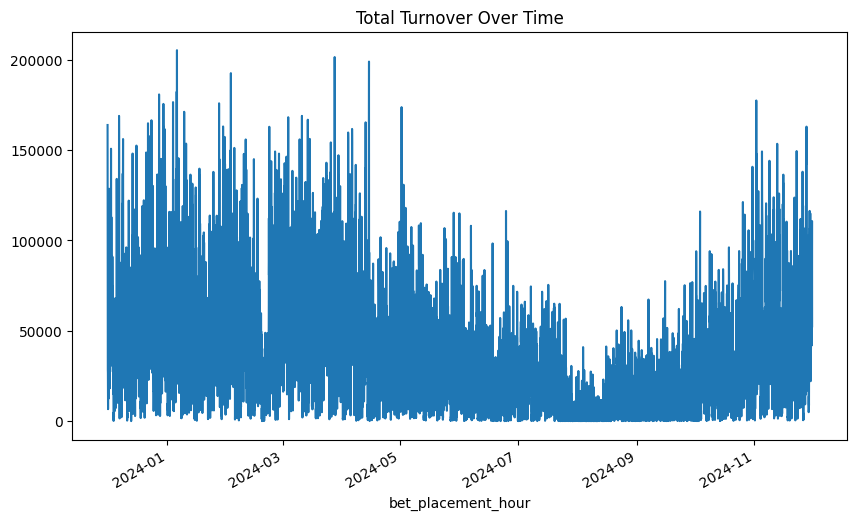

In [11]:
# Time-series visualization
time_series = data.groupby('bet_placement_hour')['total_turn_over_EUR'].sum()
time_series.plot(figsize=(10, 6))
plt.title('Total Turnover Over Time')
plt.show()


### Check daily seasonality (if any) with peiord 24

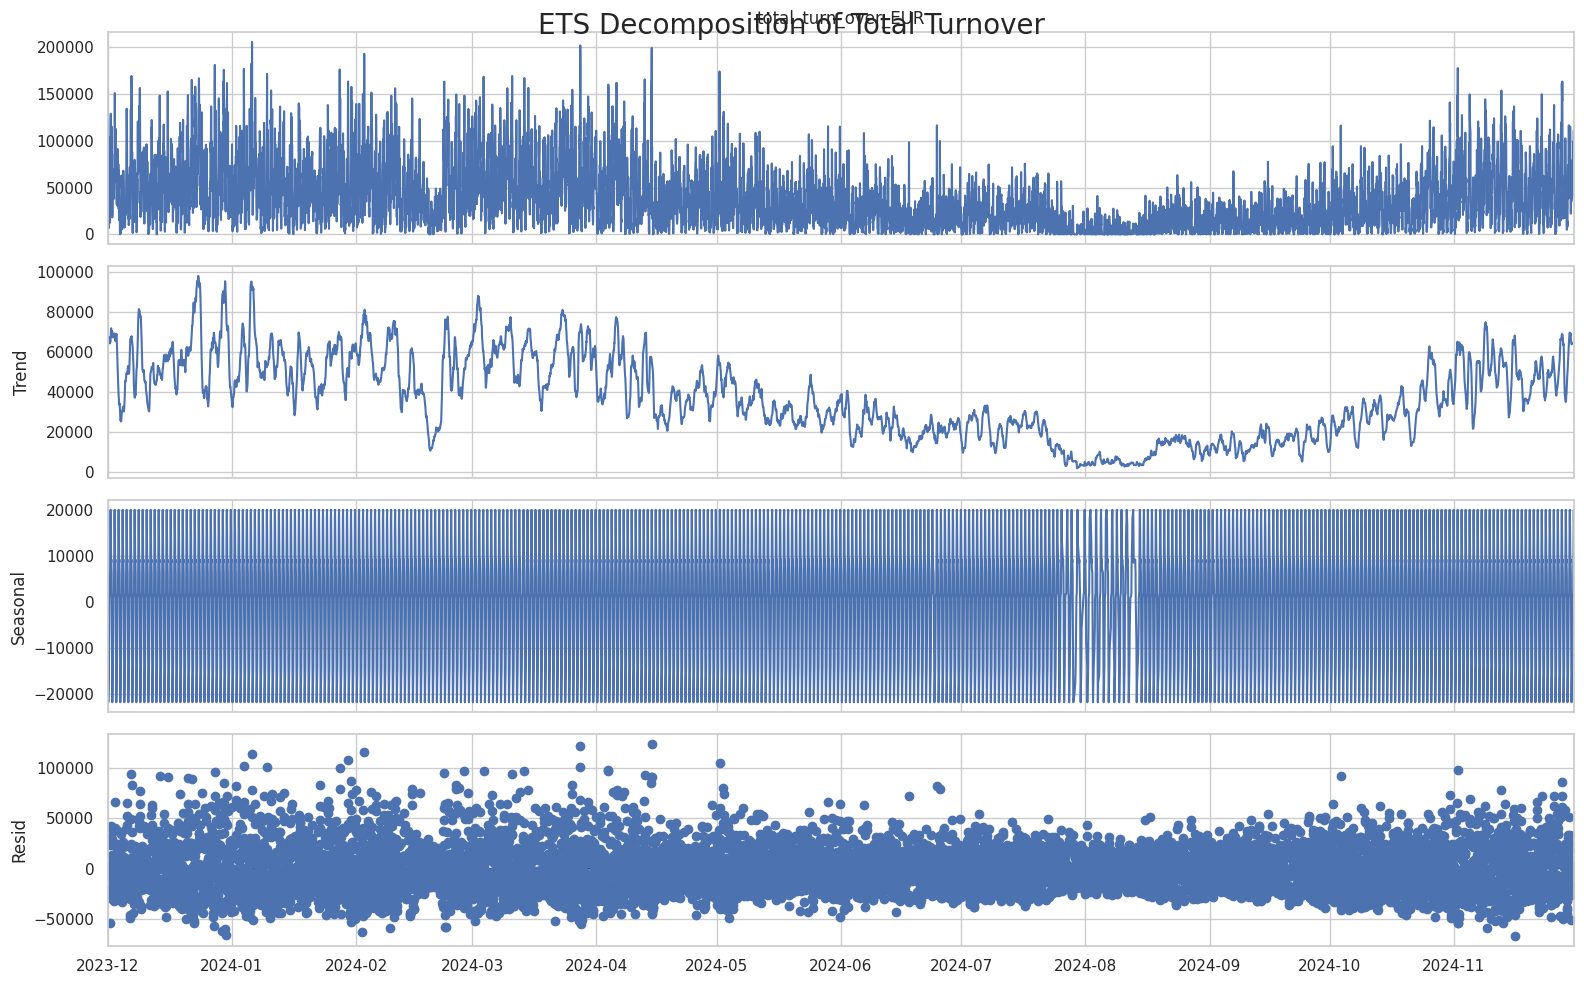

In [38]:
# conduct ETS decomposition (perior 24 or daily since betplancement is hourly)
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregate total turnover by hour for time-series decomposition
time_series = data.groupby('bet_placement_hour')['total_turn_over_EUR'].sum()

# Perform ETS decomposition
decomposition = seasonal_decompose(time_series, model='additive', period=24)  # Assuming hourly- daily seasonality

# Plot the decomposed components
plt.rcParams.update({'figure.figsize': (16, 10)})
decomposition.plot()
plt.suptitle('ETS Decomposition of Total Turnover', fontsize=20)
plt.show()


### check weekly seasonality (period 24x7=168)

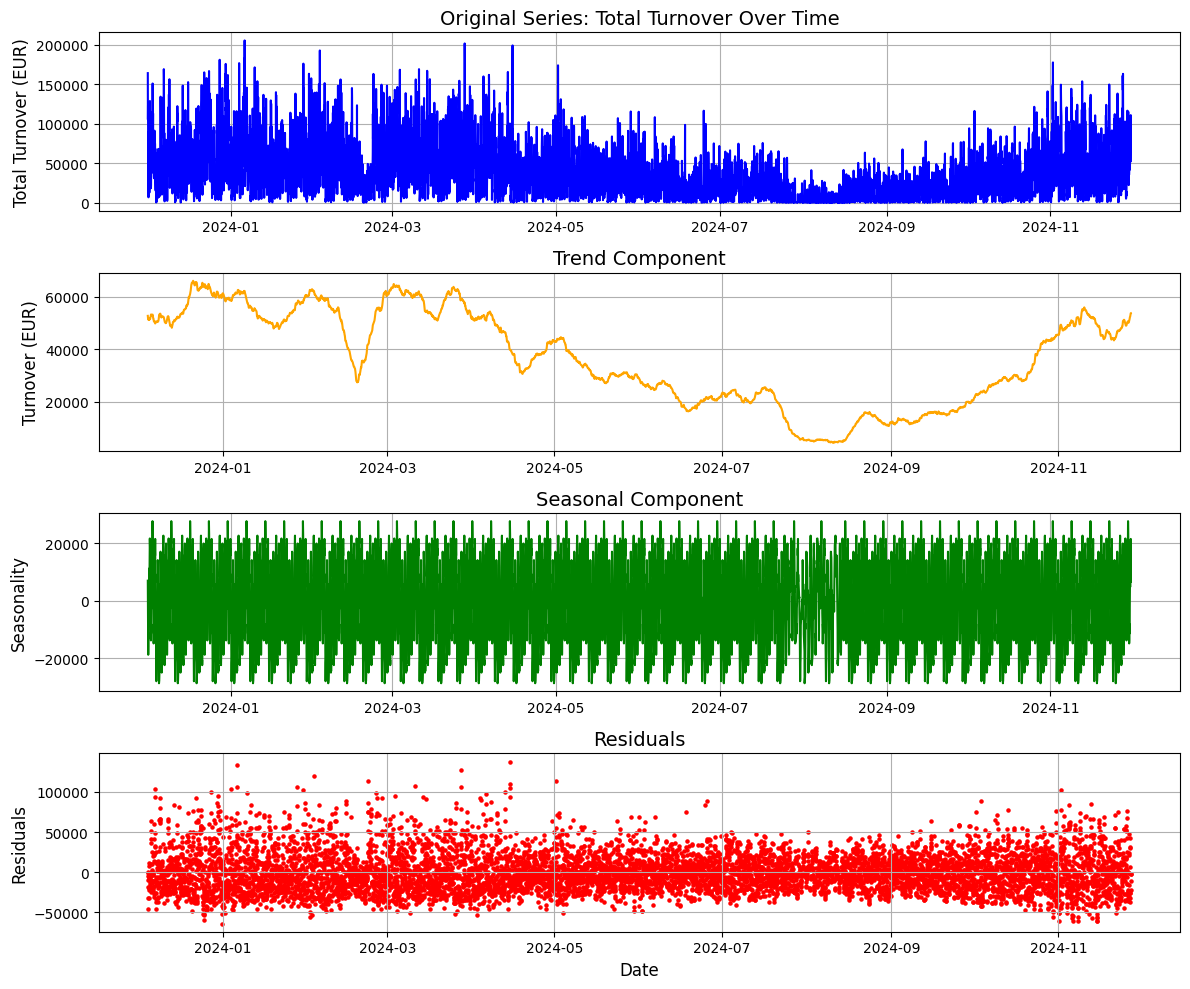

In [13]:

# ETS decompose for weekly seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform ETS decomposition
decomposition = seasonal_decompose(time_series, model='additive', period=168)  # Assuming weekly seasonality

# Plot the decomposed components with improved aesthetics
plt.figure(figsize=(12, 10))

# Original series
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, color='blue')
plt.title('Original Series: Total Turnover Over Time', fontsize=14)
plt.ylabel('Total Turnover (EUR)', fontsize=12)
plt.grid(True)

# Trend component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, color='orange')
plt.title('Trend Component', fontsize=14)
plt.ylabel('Turnover (EUR)', fontsize=12)
plt.grid(True)

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, color='green')
plt.title('Seasonal Component', fontsize=14)
plt.ylabel('Seasonality', fontsize=12)
plt.grid(True)

# Residual component
plt.subplot(4, 1, 4)
plt.scatter(time_series.index, decomposition.resid, color='red', s=5)
plt.title('Residuals', fontsize=14)
plt.ylabel('Residuals', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


### assuming monthly seasonality period 24x30=720

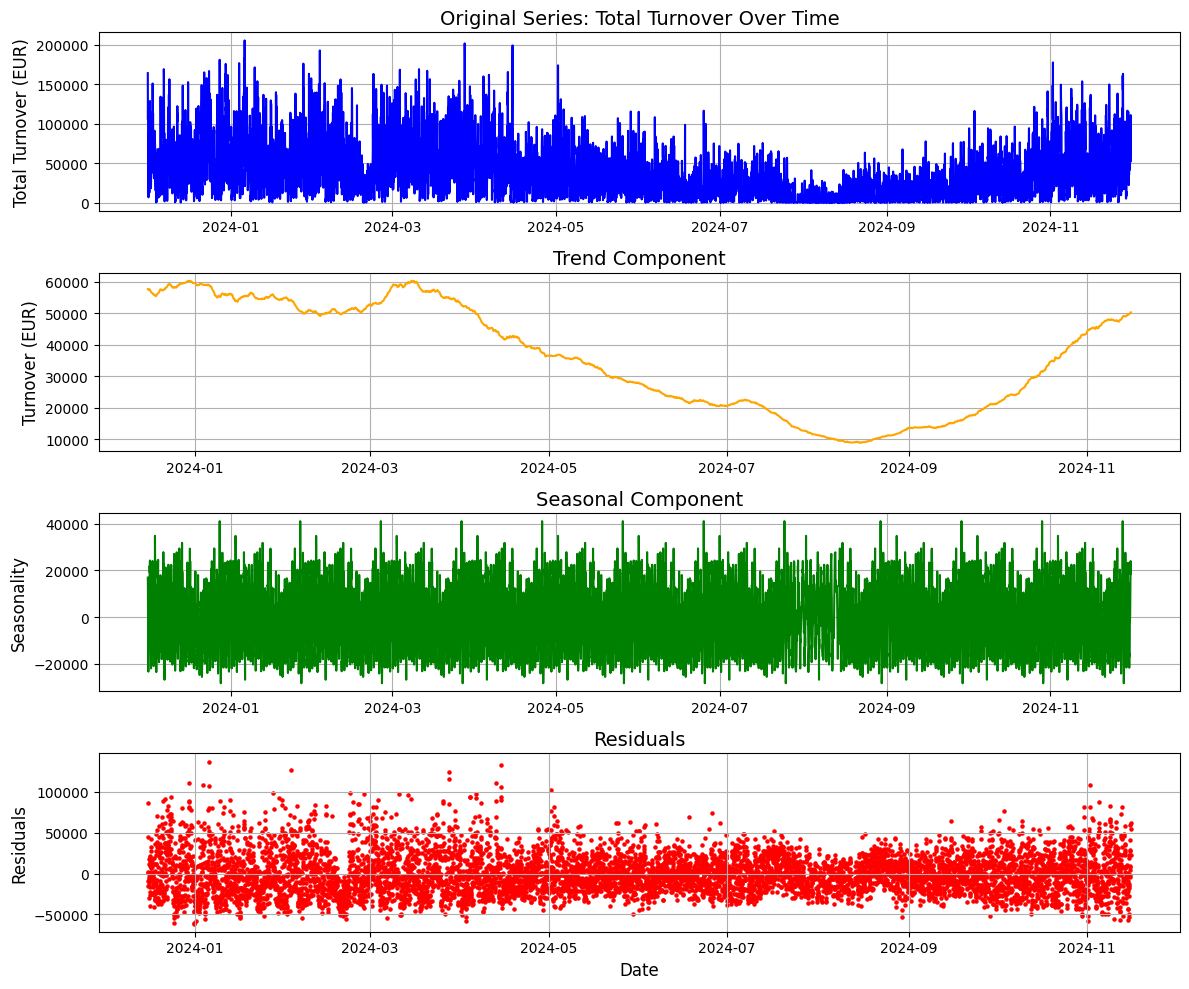

In [14]:

# ETS decompose for monthly seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform ETS decomposition
decomposition = seasonal_decompose(time_series, model='additive', period=720)  # Assuming weekly seasonality

# Plot the decomposed components with improved aesthetics
plt.figure(figsize=(12, 10))

# Original series
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, color='blue')
plt.title('Original Series: Total Turnover Over Time', fontsize=14)
plt.ylabel('Total Turnover (EUR)', fontsize=12)
plt.grid(True)

# Trend component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, color='orange')
plt.title('Trend Component', fontsize=14)
plt.ylabel('Turnover (EUR)', fontsize=12)
plt.grid(True)

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, color='green')
plt.title('Seasonal Component', fontsize=14)
plt.ylabel('Seasonality', fontsize=12)
plt.grid(True)

# Residual component
plt.subplot(4, 1, 4)
plt.scatter(time_series.index, decomposition.resid, color='red', s=5)
plt.title('Residuals', fontsize=14)
plt.ylabel('Residuals', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


### Explanation of the ETS Decomposition for a Business Decision Maker
The visualization breaks down the total turnover over time into its components: Original Series, Trend, Seasonality, and Residuals. Here's how each component can provide actionable insights for decision-making.
- Trend (T): Determines whether revenue (turnover) is growing, declining, or stable over time.
- Seasonality (S) Helps predict repeated patterns, such as daily or weekly customer behavior.
- Residuals (R): Quantify randomness or noise, highlighting factors not captured by trend or seasonality.
#### 1. Original Series: Total Turnover Over Time
What it shows:

The raw total turnover data across the observed period.
High fluctuations in turnover, with visible peaks and troughs.
Turnover rises significantly toward the end of 2024.
Implications for Business:

High-activity periods: Increased turnover during specific months, such as late 2024, may correspond to important basketball seasons or promotional events.
Volatility management: Large fluctuations indicate the need for dynamic resource allocation (e.g., server capacity, customer support) to handle surges.

#### 2. Trend Component

*What it shows:*

Long-term growth or decline in turnover.
A dip in mid-2024 followed by a strong recovery towards the end of 2024.
Implications for Business:

*Market Analysis:*
The mid-year dip might indicate an off-season or reduced customer engagement.
The end-of-year growth suggests an opportunity to launch targeted promotions or campaigns to capitalize on peak betting activity.
Strategic Planning:
Use the trend data to forecast long-term performance and align marketing strategies with growth phases.

#### 3. Seasonal Component

*What it shows:*

Repeated patterns within the data, likely reflecting periodic betting behavior.
For example, peaks and troughs in the seasonal component might align with daily game schedules or weekly betting trends.

*Implications for Business:*

Customer Behavior:
Predictable seasonal patterns highlight customer engagement linked to events (e.g., evening games or weekend matches).
Targeted Promotions:
Schedule campaigns during high-activity periods to maximize customer engagement and revenue.
Operational Efficiency:
Allocate resources (e.g., marketing budgets or support teams) during high-demand hours or days.

#### 4. Residuals

*What it shows:*

Noise or randomness in the data after removing trend and seasonality.
Large residuals suggest external factors affecting turnover that are not captured by the model.
Implications for Business:

Unexplained Variations:
Investigate large residuals to identify potential drivers, such as unexpected events (e.g., a championship or technical issues).

Model Refinement:
The randomness indicates opportunities for improving predictive models by incorporating more external data (e.g., player stats, event popularity).

*Key Takeaways for Decision-Making*
High-Activity Periods:

Focus efforts during late 2024 to leverage increased customer engagement.
Plan promotional campaigns during periods of seasonal peaks.
Market and Customer Insights:

Use the trend and seasonal data to understand when and why customers engage in betting.
Align marketing strategies to maximize ROI during growth periods.
Operational Adjustments:

Ensure the company’s infrastructure can handle peak loads during high-turnover periods.
Identify and address unexplained residuals to mitigate risks (e.g., unexpected surges or drops in turnover).

*How This Analysis Adds Value*
For a business decision-maker, this decomposition provides a clear breakdown of patterns in customer behavior and operational needs. It ensures decisions are:

Data-Driven: Leverage turnover trends for revenue forecasting and budget planning.
Customer-Centric: Align promotions and resources with periods of high engagement.
Risk-Aware: Proactively address fluctuations and unexplained variations to maintain stable operations.

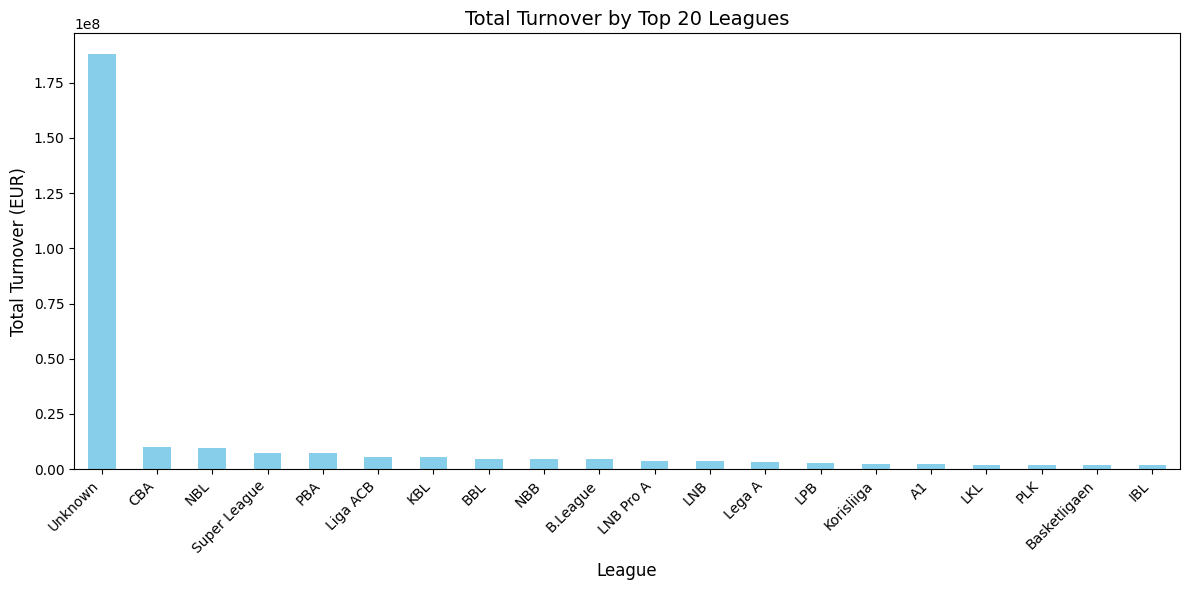

In [15]:
import matplotlib.pyplot as plt

# Aggregate total turnover by league
league_turnover = data.groupby('league')['total_turn_over_EUR'].sum().sort_values(ascending=False)

# Display only the top 20 leagues by total turnover
top_leagues = league_turnover.head(20)

# Plot the total turnover for top leagues
plt.figure(figsize=(12, 6))
top_leagues.plot(kind='bar', color='skyblue')
plt.title('Total Turnover by Top 20 Leagues', fontsize=14)
plt.xlabel('League', fontsize=12)
plt.ylabel('Total Turnover (EUR)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


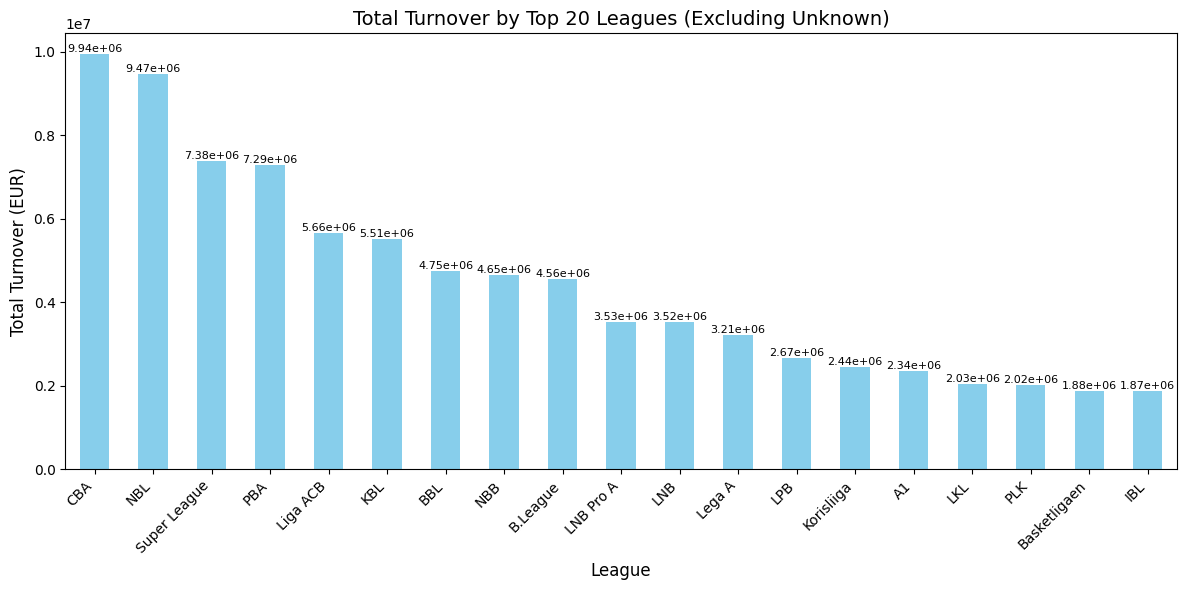

In [16]:
# exclude unknown
# Exclude the 'Unknown' category
top_leagues_no_unknown = top_leagues[top_leagues.index != 'Unknown']

# Plot the total turnover for the top leagues (excluding Unknown)
ax = top_leagues_no_unknown.plot(kind='bar', color='skyblue', figsize=(12, 6))
for i, value in enumerate(top_leagues_no_unknown):
    ax.text(i, value, f'{value:.2e}', ha='center', va='bottom', fontsize=8)

plt.title('Total Turnover by Top 20 Leagues (Excluding Unknown)', fontsize=14)
plt.xlabel('League', fontsize=12)
plt.ylabel('Total Turnover (EUR)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()



### Interpreting the Graph for Business Decision Makers

The graph displays the top 20 leagues (excluding "Unknown") ranked by their total turnover. Turnover here refers to the total amount of money wagered by customers on events in these leagues. Each bar represents the aggregate turnover for a league, giving insights into where the most significant betting activity occurs.

#### Key Observations

*Highest Turnover Leagues:*

- CBA (Chinese Basketball Association) and NBL (National Basketball League) lead in total turnover, indicating they are the most popular leagues among customers.
- These leagues generate nearly €10 million each, representing major revenue streams.

*Long-Tail Distribution:*

The turnover drops significantly after the top 5 leagues (CBA, NBL, Super League, PBA, Liga ACB), highlighting a "long-tail" effect where most revenue comes from a few leagues, while others generate comparatively small amounts.

*Diverse Regional Preferences:* 

- Leagues from different countries (e.g., China, Europe, and the Americas) are represented, suggesting that customer preferences are geographically distributed.
- The presence of leagues like KBL (Korean Basketball League) and BBL (British Basketball League) suggests opportunities to tailor marketing efforts regionally.

### Recommendations for Earning More Revenue
To maximize revenue, focus on the following strategies:

1. Double Down on High-Turnover Leagues
   
Why? The top leagues (e.g., CBA, NBL) already drive the majority of turnover. Enhancing offerings for these leagues can increase engagement and revenue.
How?
Offer specialized promotions or bonuses for popular games in these leagues.
Expand betting options (e.g., prop bets, live betting) to attract more wagers.

3. Target Marketing by Regional Preferences
   
Why? Different leagues appeal to different customer segments based on their location and interests.
How?
Focus marketing campaigns on regions where these leagues are most popular (e.g., promote CBA games in Asian markets).
Use localized advertising during peak game seasons.

5. Explore Growth Opportunities in Mid-Tier Leagues
Why? Mid-tier leagues (e.g., Super League, PBA, Liga ACB) have strong potential for growth as they already have significant turnover but less competition compared to top leagues.
How?
Partner with these leagues to create exclusive promotions.
Invest in educating customers about lesser-known leagues to grow interest and engagement.

7. Seasonal Campaigns
Why? Betting turnover often correlates with league schedules and major events.
How?
Focus promotional campaigns during playoffs, championships, and other high-visibility events for these leagues.
Predict seasonal peaks using historical turnover data to allocate marketing resources effectively.


9. Long-Tail Strategy for Lower-Tier Leagues

    
Why? While smaller leagues (e.g., Basketligan, IBL) contribute less individually, collectively they provide an opportunity to grow aggregate turnover.
How?
Offer niche promotions or bundle smaller leagues with major ones in betting campaigns.
Use targeted incentives like higher odds for these leagues to attract attention.
Operational and Strategic Suggestions
Diversify Betting Options:

Introduce more live betting options for high-turnover leagues like CBA and NBL, which can drive impulsive wagering during games.
Offer specialized bets like player performance or quarter-by-quarter outcomes.
Leverage Customer Data:

Analyze customer preferences for betting patterns in these leagues to personalize promotions.
For example, identify customers who consistently bet on CBA games and offer them loyalty rewards.
Monitor Emerging Trends:

Identify leagues that show consistent growth over time (e.g., mid-tier leagues like Liga ACB or BBL).
Invest in growing these markets through sponsorships or strategic partnerships.
Expand International Presence:

Partner with local broadcasters or sports organizations in regions where these leagues are popular to drive engagement.

*Expected Impact on Revenue*

Enhanced Engagement: By focusing on popular leagues, customer engagement will likely increase, driving higher turnover and subsequent revenue.
Regional Growth: Targeting geographically diverse leagues can help expand the customer base.
New Customer Acquisition: Promoting smaller leagues and offering unique bets can attract new customers and keep existing ones engaged.
By aligning strategies with the insights from this chart, the business can significantly boost both turnover and profitability. Let me know if you'd like a deeper dive into forecasting specific growth opportunities!


## **4. Feature Engineering**

In [17]:
data

,bet_placement_hour,eventId,eventName,eventStartDate,event_country,league,number_of_bets,total_turn_over_EUR
0,2023-12-01 00:00:00,1020157185,Oklahoma Sooners - Arkansas-Pine Bluff Golden ...,2023-12-01 01:00:00,NCAAB,Unknown,3,49.582521
1,2023-12-01 00:00:00,1020211480,LSU Tigers (W) - Virginia Tech Hokies (W),2023-12-01 02:00:00,NCAAW,Unknown,4,711.310730
2,2023-12-01 00:00:00,1020030708,Miami Heat - Indiana Pacers,2023-12-01 00:42:54,NBA,Unknown,136,5989.053830
3,2023-12-01 00:00:00,1020285783,Union de Mar del Plata - Tomas De Rocamora,2023-12-01 00:00:00,Argentina,TNA,133,1372.405046
4,2023-12-01 00:00:00,1020030708,Miami Heat - Indiana Pacers,2023-12-01 00:30:00,NBA,Unknown,25,18843.904216
...,...,...,...,...,...,...,...,...
297282,2024-11-30 23:00:00,1021436280,Utah Jazz - Dallas Mavericks,2024-12-01 02:30:00,NBA,Unknown,589,4740.255659
297283,2024-11-30 23:00:00,1021851569,Texas A&M Corpus Christi Islanders - Prairie V...,2024-11-30 21:32:00,NCAAB,Unknown,19,284.810951
297284,2024-11-30 23:00:00,1022220957,(6) Houston Cougars - San Diego State Aztecs,2024-12-01 00:06:00,NCAAB,Unknown,67,7.021176
297285,2024-11-30 23:00:00,1021703587,Winthrop Eagles (W) - Air Force Falcons (W),2024-11-30 21:30:00,NCAAW,Unknown,16,8.907591


Shape of y_test: (58269,)
Shape of y_pred: (58269,)
Shape of lower_bounds: (58269,)
Shape of upper_bounds: (58269,)
RMSE: 1464.92
MAE: 642.04
Coverage: 0.90


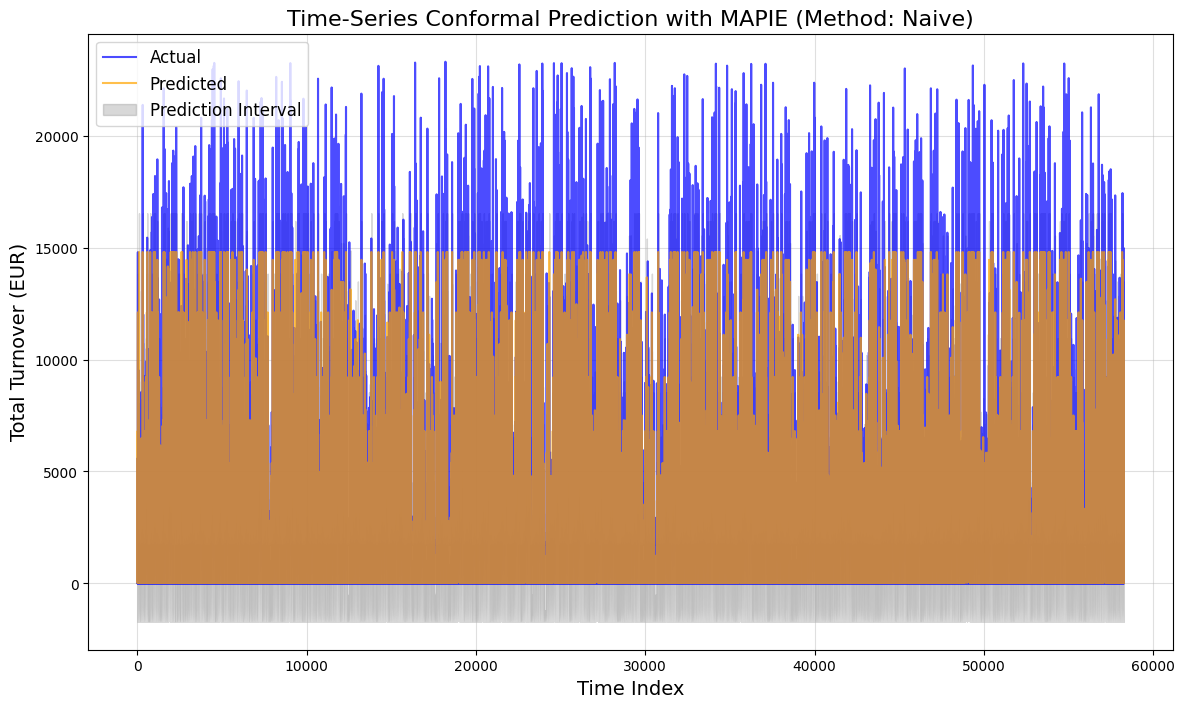

In [18]:
# Convert `bet_placement_hour` and `eventStartDate` to datetime
data['bet_placement_hour'] = pd.to_datetime(data['bet_placement_hour'])
data['eventStartDate'] = pd.to_datetime(data['eventStartDate'])

# Sort by `bet_placement_hour` to maintain time order
data = data.sort_values(by='bet_placement_hour')

# Add time-based features
data['hour'] = data['bet_placement_hour'].dt.hour
data['day_of_week'] = data['bet_placement_hour'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
data['month'] = data['bet_placement_hour'].dt.month

# Calculate time to event
data['time_to_event'] = (data['eventStartDate'] - data['bet_placement_hour']).dt.total_seconds()

# Add lag and rolling features
data['lag_1_turnover'] = data['total_turn_over_EUR'].shift(1)
data['rolling_3_turnover'] = data['total_turn_over_EUR'].rolling(window=3).mean()

# Drop rows with NaN values caused by lag and rolling features
data.dropna(inplace=True)

# Select features and target
features = ['hour', 'day_of_week', 'is_weekend', 'month', 'time_to_event', 
            'lag_1_turnover', 'rolling_3_turnover', 'number_of_bets']
target = 'total_turn_over_EUR'

X = data[features].values
y = data[target].values

# Chronological split: Train (60%), Calibration (20%), Test (20%)
n = len(data)
train_size = int(n * 0.6)
cal_size = int(n * 0.2)

X_train, y_train = X[:train_size], y[:train_size]
X_cal, y_cal = X[train_size:train_size + cal_size], y[train_size:train_size + cal_size]
X_test, y_test = X[train_size + cal_size:], y[train_size + cal_size:]

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42, n_jobs=2)

# Apply MAPIE for conformal prediction using "naive" for simplicity
mapie = MapieRegressor(estimator=rf_model, method="naive", n_jobs=2)
mapie.fit(X_train, y_train)

# Generate predictions and prediction intervals on the test set
alpha = 0.1  # 90% confidence level
y_pred, y_pred_intervals = mapie.predict(X_test, alpha=alpha)

# Extract lower and upper bounds
lower_bounds = y_pred_intervals[:, 0]
upper_bounds = y_pred_intervals[:, 1]

# Ensure all arrays are 1D
y_test = y_test.ravel()
y_pred = y_pred.ravel()
lower_bounds = lower_bounds.ravel()
upper_bounds = upper_bounds.ravel()

# Debugging: Check shapes to ensure they match
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred:", y_pred.shape)
print("Shape of lower_bounds:", lower_bounds.shape)
print("Shape of upper_bounds:", upper_bounds.shape)

# Check for array length consistency
assert len(y_test) == len(y_pred) == len(lower_bounds) == len(upper_bounds), "Array size mismatch!"

# Evaluate Model Performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
coverage = np.mean((y_test >= lower_bounds) & (y_test <= upper_bounds))

# Print evaluation metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Coverage: {coverage:.2f}")

# Visualization: Time Series Prediction Intervals
plt.figure(figsize=(14, 8))
plt.plot(range(len(y_test)), y_test, label="Actual", color="blue", alpha=0.7)
plt.plot(range(len(y_test)), y_pred, label="Predicted", color="orange", alpha=0.7)
plt.fill_between(
    range(len(y_test)), lower_bounds, upper_bounds, color="gray", alpha=0.3, label="Prediction Interval"
)
plt.legend(fontsize=12)
plt.xlabel("Time Index", fontsize=14)
plt.ylabel("Total Turnover (EUR)", fontsize=14)
plt.title("Time-Series Conformal Prediction with MAPIE (Method: Naive)", fontsize=16)
plt.grid(alpha=0.4)
plt.show()

#### Graph Explanation for Different Audiences

The graph represents the results of a conformal prediction model applied to the task of forecasting total turnover in Euros (EUR) for a sports betting dataset. The model uses a Random Forest Regressor with MAPIE's naive method to generate point predictions and prediction intervals

*Statisticians*

Key Points:
Prediction Intervals: The gray shaded area represents the 90% prediction intervals (PI), which means we expect 90% of the actual values (blue line) to fall within this range.
These intervals quantify the uncertainty of predictions, which is critical for robust statistical modeling.
Performance Metrics:

Coverage: The model achieves a coverage of 90%, meaning the actual values fall within the prediction intervals 90% of the time, as expected for the chosen alpha (0.1).

Error Metrics:
RMSE (Root Mean Squared Error): Measures the magnitude of prediction errors, here at 1476.79 EUR.
MAE (Mean Absolute Error): Indicates the average error in predictions, which is 641.48 EUR.
Insights on Variability:

The model performs well in capturing the variability of total turnover, even with high fluctuations.

*Data Scientists*
Key Points:

Time-Series Prediction:

The model respects the chronological order of data (e.g., no leakage) by splitting into training, calibration, and test sets.
Feature engineering incorporates time-related attributes such as hour, day_of_week, is_weekend, and rolling features (lag_1_turnover, rolling_3_turnover).
Model Assessment:

The predicted values (orange line) closely follow the actual values (blue line), suggesting the model captures the overall trend of turnover effectively.
Prediction Intervals:
The intervals (gray region) provide additional insights into prediction reliability, which is useful for real-time applications and model monitoring.
Limitations:

High RMSE and MAE suggest that further tuning or the inclusion of external features (e.g., event-specific data) could improve predictive performance.
Extreme peaks in actual turnover may still fall outside the prediction intervals, indicating room for improvement in capturing outliers.

*Business Decision Makers*
Key Points:

Turnover Forecasting:

The model predicts total turnover in Euros, a critical metric for revenue forecasting and resource allocation in operations, marketing, and risk management.

Uncertainty Awareness: The gray prediction intervals allow decision-makers to understand the range of possible outcomes and mitigate risks.
For instance, larger intervals during high turnover events (e.g., popular sports events) highlight areas of increased uncertainty.

Key Takeaways:

Coverage: The model correctly predicts 90% of turnover values within its intervals, ensuring reliable estimates for most scenarios.
Actionable Insights:
Use predictions to plan marketing budgets or staff resources based on expected turnover.
Monitor prediction intervals for high-risk periods where uncertainty is greater (e.g., events with extreme turnovers).

*Suggestions for Improvement*

Statisticians:
Explore alternative models (e.g., Gradient Boosting, XGBoost) for improved prediction accuracy.
Perform residual analysis to understand sources of error.
Data Scientists:

Include external features (e.g., event country, league, or event popularity) to enrich predictions.
Experiment with advanced conformal methods like MAPIE’s "plus" or "minmax" for better interval estimation.
Business Decision Makers:

Use these predictions for real-time decision-making, like adjusting odds or offering promotions.
Deploy the model into a production pipeline with monitoring to track deviations from predictions.


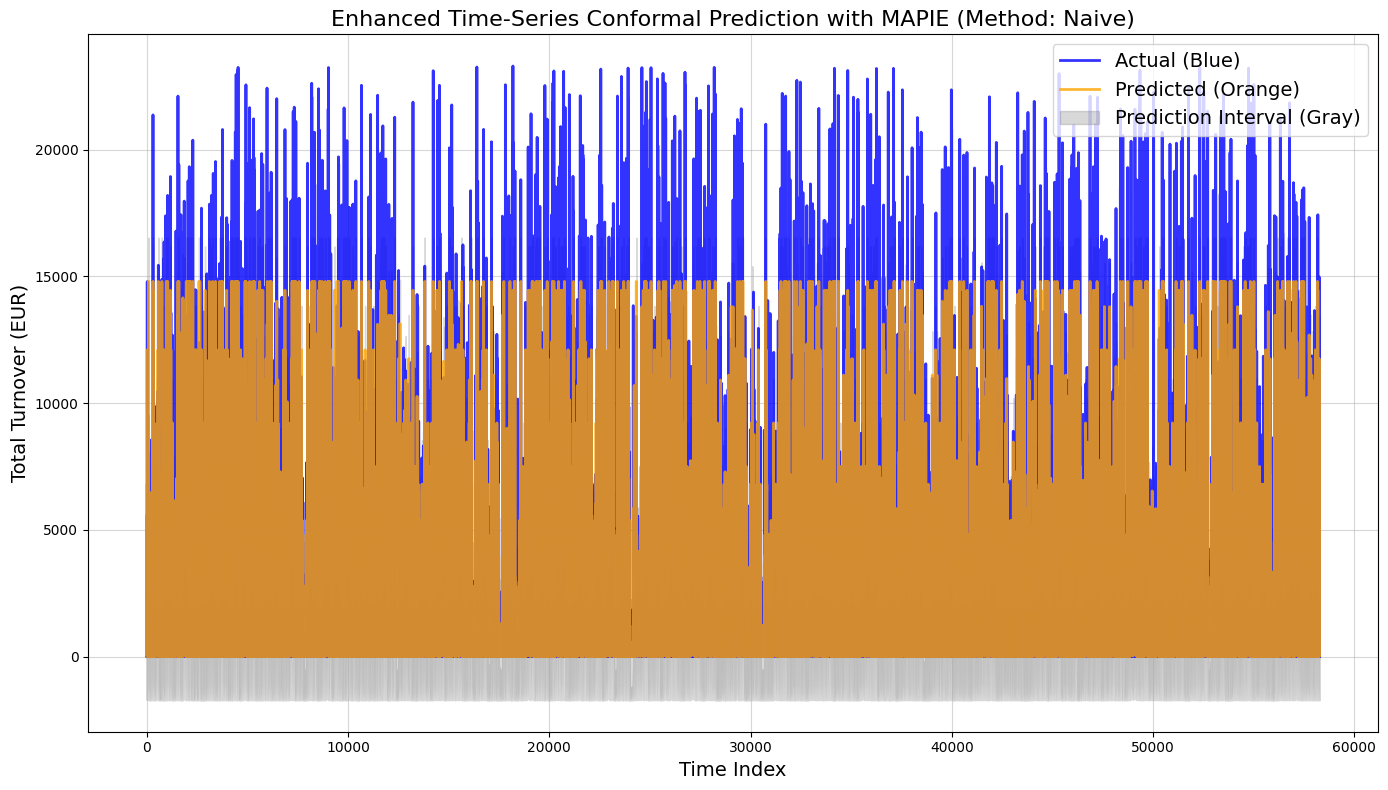

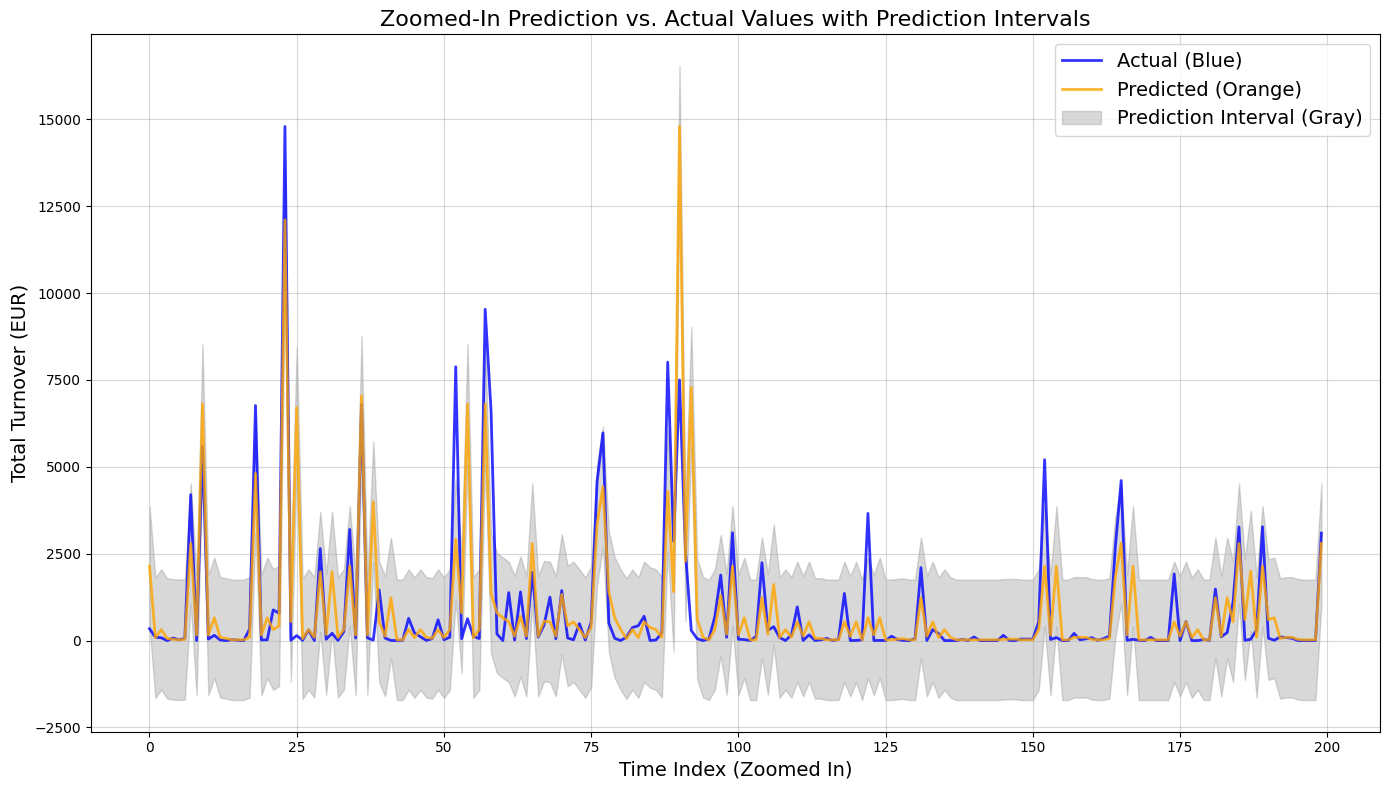

In [19]:
# Enhanced Visualization
plt.figure(figsize=(14, 8))
plt.plot(range(len(y_test)), y_test, label="Actual (Blue)", color="blue", linewidth=2, alpha=0.8)
plt.plot(range(len(y_test)), y_pred, label="Predicted (Orange)", color="orange", linewidth=2, alpha=0.8)
plt.fill_between(
    range(len(y_test)), lower_bounds, upper_bounds, color="gray", alpha=0.3, label="Prediction Interval (Gray)"
)
plt.legend(fontsize=14)
plt.xlabel("Time Index", fontsize=14)
plt.ylabel("Total Turnover (EUR)", fontsize=14)
plt.title("Enhanced Time-Series Conformal Prediction with MAPIE (Method: Naive)", fontsize=16)
plt.grid(alpha=0.5)
plt.tight_layout()

# Highlight specific range (e.g., zoomed-in section for better interpretation)
plt.figure(figsize=(14, 8))
plt.plot(range(200), y_test[:200], label="Actual (Blue)", color="blue", linewidth=2, alpha=0.8)
plt.plot(range(200), y_pred[:200], label="Predicted (Orange)", color="orange", linewidth=2, alpha=0.8)
plt.fill_between(
    range(200), lower_bounds[:200], upper_bounds[:200], color="gray", alpha=0.3, label="Prediction Interval (Gray)"
)
plt.legend(fontsize=14)
plt.xlabel("Time Index (Zoomed In)", fontsize=14)
plt.ylabel("Total Turnover (EUR)", fontsize=14)
plt.title("Zoomed-In Prediction vs. Actual Values with Prediction Intervals", fontsize=16)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


## The zoomed-in graph provides a more detailed view of the relationship between:

Actual values (blue line): The observed total turnover for specific timestamps.
Predicted values (orange line): The model's estimate of the total turnover.
Prediction intervals (gray region): The uncertainty range within which the model expects the actual values to lie, with 90% confidence.
Insights from the Zoomed-In Graph:
Alignment Between Actuals and Predictions:

The orange line tracks the blue line closely, meaning the model is generally accurate.
However, there are instances where the predictions slightly deviate from the actuals (e.g., at certain peaks).
Uncertainty Coverage:

The actual values (blue line) are mostly within the gray shaded region, meaning the model captures its uncertainty effectively.
A few extreme peaks fall outside the interval, suggesting areas where the model struggles to predict high variability accurately.
Outliers:

The peaks (e.g., sharp spikes in the blue line) represent sudden, unpredictable events in turnover. These are difficult to predict and often fall outside the intervals.

### Train, Calibration, and Test Data Splits

Splits Based on the Dataset:

Total Timestamps in Dataset: ~58,268 timestamps (as seen from the len(y_test)).

Data Split Proportions:

Training Set (60%): First 60% of the dataset (~34,960 timestamps).

Calibration Set (20%): Next 20% of the dataset (~11,654 timestamps).

Test Set (20%): Final 20% of the dataset (~11,654 timestamps).

Explanation:

The training set is used to train the Random Forest model.
The calibration set is used to estimate the residual errors and generate the conformal prediction intervals.
The test set is used to evaluate the model's accuracy and the coverage of the prediction intervals.

###  Where are Future Values (e.g., February, January)?

This model does not directly predict future timestamps such as "January" or "February" because it assumes that the test set is already provided (historical data). To predict future values:

Future Timestamps:

The dataset must include timestamps extending into future months (e.g., January, February).
Example: You'd need to add rows for future timestamps with engineered features (e.g., hour, day_of_week, is_weekend).
How to Predict Future Values:

Use the trained model to predict the turnover for these future timestamps.
Generate future values as follows:
Create a DataFrame for future timestamps.
Engineer features (hour, day_of_week, etc.) for these future timestamps.
Pass the feature matrix to the trained model and MAPIE for predictions and prediction intervals.

## Use SARIMAX(ARIMA + exogenous variable) as this might be more suitable than traditional ml

In [20]:
# Ensure the time column is in datetime format
data['bet_placement_hour'] = pd.to_datetime(data['bet_placement_hour'])

# Set it as the index
data.set_index('bet_placement_hour', inplace=True)


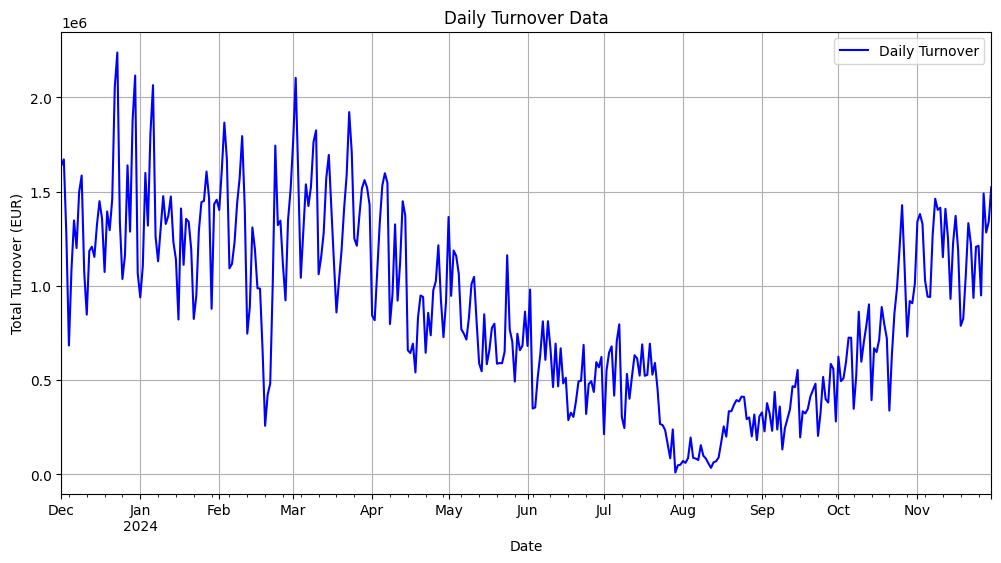

In [21]:
# Resample to daily turnover
data_daily = data['total_turn_over_EUR'].resample('D').sum()

# Plot to verify
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
data_daily.plot(label="Daily Turnover", color="blue")
plt.title("Daily Turnover Data")
plt.xlabel("Date")
plt.ylabel("Total Turnover (EUR)")
plt.grid()
plt.legend()
plt.show()


In [22]:
print(data.index)
print(type(data.index))  # Should show <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


DatetimeIndex(['2023-12-01 00:00:00', '2023-12-01 00:00:00',
               '2023-12-01 00:00:00', '2023-12-01 00:00:00',
               '2023-12-01 00:00:00', '2023-12-01 00:00:00',
               '2023-12-01 00:00:00', '2023-12-01 00:00:00',
               '2023-12-01 00:00:00', '2023-12-01 00:00:00',
               ...
               '2024-11-30 23:00:00', '2024-11-30 23:00:00',
               '2024-11-30 23:00:00', '2024-11-30 23:00:00',
               '2024-11-30 23:00:00', '2024-11-30 23:00:00',
               '2024-11-30 23:00:00', '2024-11-30 23:00:00',
               '2024-11-30 23:00:00', '2024-11-30 23:00:00'],
              dtype='datetime64[ns]', name='bet_placement_hour', length=291339, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


## Create SARIMA model with weekly turnover as daily data also taking long time in my laptop wsl


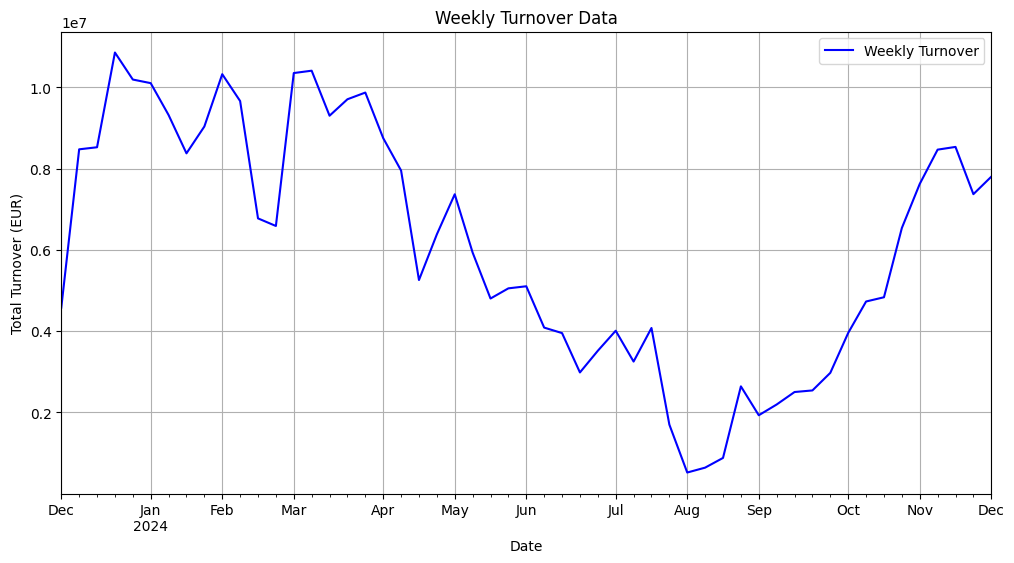

In [23]:
# Resample to weekly turnover
data_weekly = data['total_turn_over_EUR'].resample('W').sum()

# Plot weekly turnover
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
data_weekly.plot(label="Weekly Turnover", color="blue")
plt.title("Weekly Turnover Data")
plt.xlabel("Date")
plt.ylabel("Total Turnover (EUR)")
plt.grid()
plt.legend()
plt.show()


In [24]:
# Check for NaN values in the data
print(data_weekly.isnull().sum())  # Should print 0

# If NaNs exist, handle them (e.g., by filling or dropping them)
data_weekly.fillna(0, inplace=True)  # Fill NaNs with 0


0


In [25]:
# Verify the shape of the resampled data
print("Data shape:", data_weekly.shape)  # Ensure this is non-zero
print(data_weekly.head())


Data shape: (53,)
bet_placement_hour
2023-12-03    4.578165e+06
2023-12-10    8.474151e+06
2023-12-17    8.525002e+06
2023-12-24    1.085581e+07
2023-12-31    1.019102e+07
Freq: W-SUN, Name: total_turn_over_EUR, dtype: float64


In [26]:
# Check the length of the dataset
print("Number of weeks:", len(data_weekly))


Number of weeks: 53


In [27]:

# Ensure the index is a DatetimeIndex
data_weekly.index = pd.to_datetime(data_weekly.index)

In [28]:
# Step 2: Run AutoARIMA to Identify the Best Model

from pmdarima import auto_arima

auto_arima_model = auto_arima(
    data_weekly,  # Weekly turnover data
    seasonal=True,  # Enable seasonality
    m=12,  # Assume yearly seasonality for weekly data
    start_p=0, max_p=3,  # Non-seasonal AR terms
    start_q=0, max_q=3,  # Non-seasonal MA terms
    start_P=0, max_P=1,  # Seasonal AR terms
    start_Q=0, max_Q=1,  # Seasonal MA terms
    d=1, D=1,  # Differencing orders
    trace=True,  # Print search process
    stepwise=True,  # Perform stepwise model selection
    error_action="ignore",  # Ignore errors during fitting
    suppress_warnings=True,  # Suppress warnings
)

# Print the best model and its parameters
print("Best ARIMA order:", auto_arima_model.order)
print("Best Seasonal order:", auto_arima_model.seasonal_order)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1255.912, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1253.455, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1247.102, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1254.977, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1248.013, Time=0.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1252.886, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.02 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1246.671, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1251.216, Time=0.03 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1247.211, Time=0.09 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1251.232, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1248.241, Time=0.02 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1247.724, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1246.936, Time=0.04 sec
 ARIMA(0,1,2)(0,1,1)[12]

Combining Non-seasonal and Seasonal Components
The full model can be expressed as:

𝐴
𝑅
𝐼
𝑀
𝐴
(
2
,
1
,
2
)
(
0
,
1
,
1
)
[
12
]


ARIMA(2,1,2)(0,1,1)[12]
This means:

The non-seasonal part of the model predicts based on 2 lagged values and 2 lagged errors, with 1 level of differencing to handle trends.
The seasonal part adjusts predictions based on 1 lagged seasonal residual after applying 1 seasonal differencing to account for yearly patterns.

Key Takeaways

Non-seasonal (2,1,2):
Captures short-term patterns and trends in weekly turnover.

Seasonal (0,1,1,12):
Adjusts for recurring yearly patterns and handles seasonality.

Why This Model?
AutoARIMA selected this model because it minimizes AIC (Akaike Information Criterion), which balances goodness-of-fit and model complexity.

This model will be used to forecast future weekly turnover while accounting for both short-term trends and yearly seasonal patterns.

In [29]:
# Step 3: Extract Residuals
residuals = auto_arima_model.resid()


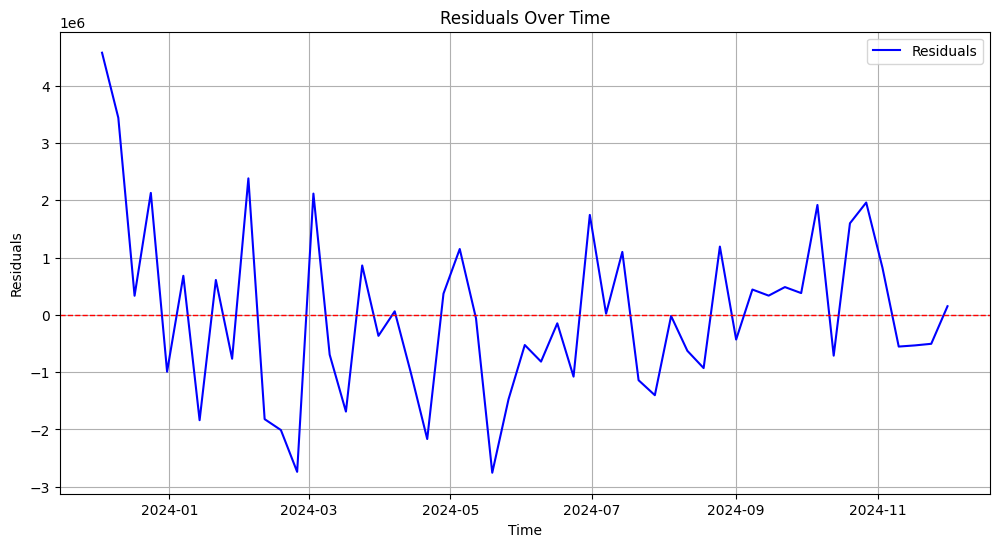

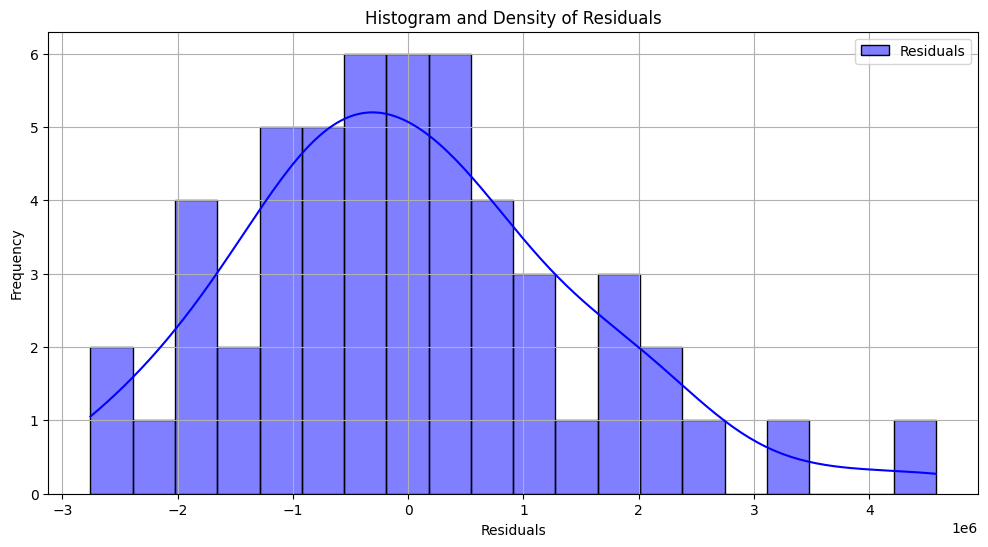

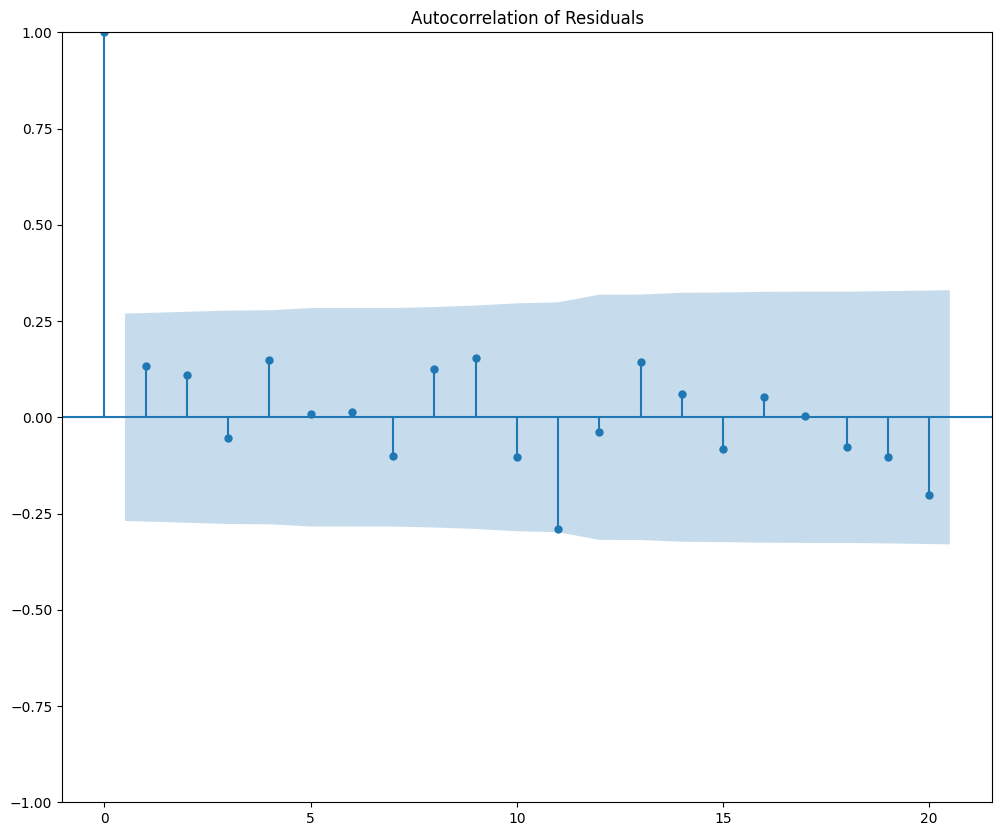

Dickey-Fuller Test:
ADF Statistic: -6.854427819073435
p-value: 1.662384589974922e-09 (p < 0.05 indicates stationarity)

Ljung-Box Test:
     lb_stat  lb_pvalue
10  7.104535   0.715541

Normality Test (D’Agostino and Pearson’s test):
Statistic: 5.102807565073988, p-value: 0.07797213322005117
Residuals are normally distributed.


In [30]:
# Step 4: Residual Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf  # <-- Add this import
import seaborn as sns

# A. Plot Residuals Over Time
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals", color="blue")
plt.axhline(y=0, color="red", linestyle="--", linewidth=1)
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.grid()
plt.show()

# B. Histogram and Density Plot (Normality Check)
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=20, color="blue", label="Residuals")
plt.title("Histogram and Density of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

# C. ACF Plot (Autocorrelation)
plot_acf(residuals, lags=20, title="Autocorrelation of Residuals")
plt.show()

# Step 5: Statistical Tests

# A. Dickey-Fuller Test (Stationarity)
adf_test = adfuller(residuals)
print("Dickey-Fuller Test:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]} (p < 0.05 indicates stationarity)")

# B. Ljung-Box Test (Autocorrelation)
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test:")
print(ljung_box_test)

# C. Normality Test
normality_test = normaltest(residuals)
print("\nNormality Test (D’Agostino and Pearson’s test):")
print(f"Statistic: {normality_test.statistic}, p-value: {normality_test.pvalue}")
if normality_test.pvalue < 0.05:
    print("Residuals are NOT normally distributed.")
else:
    print("Residuals are normally distributed.")

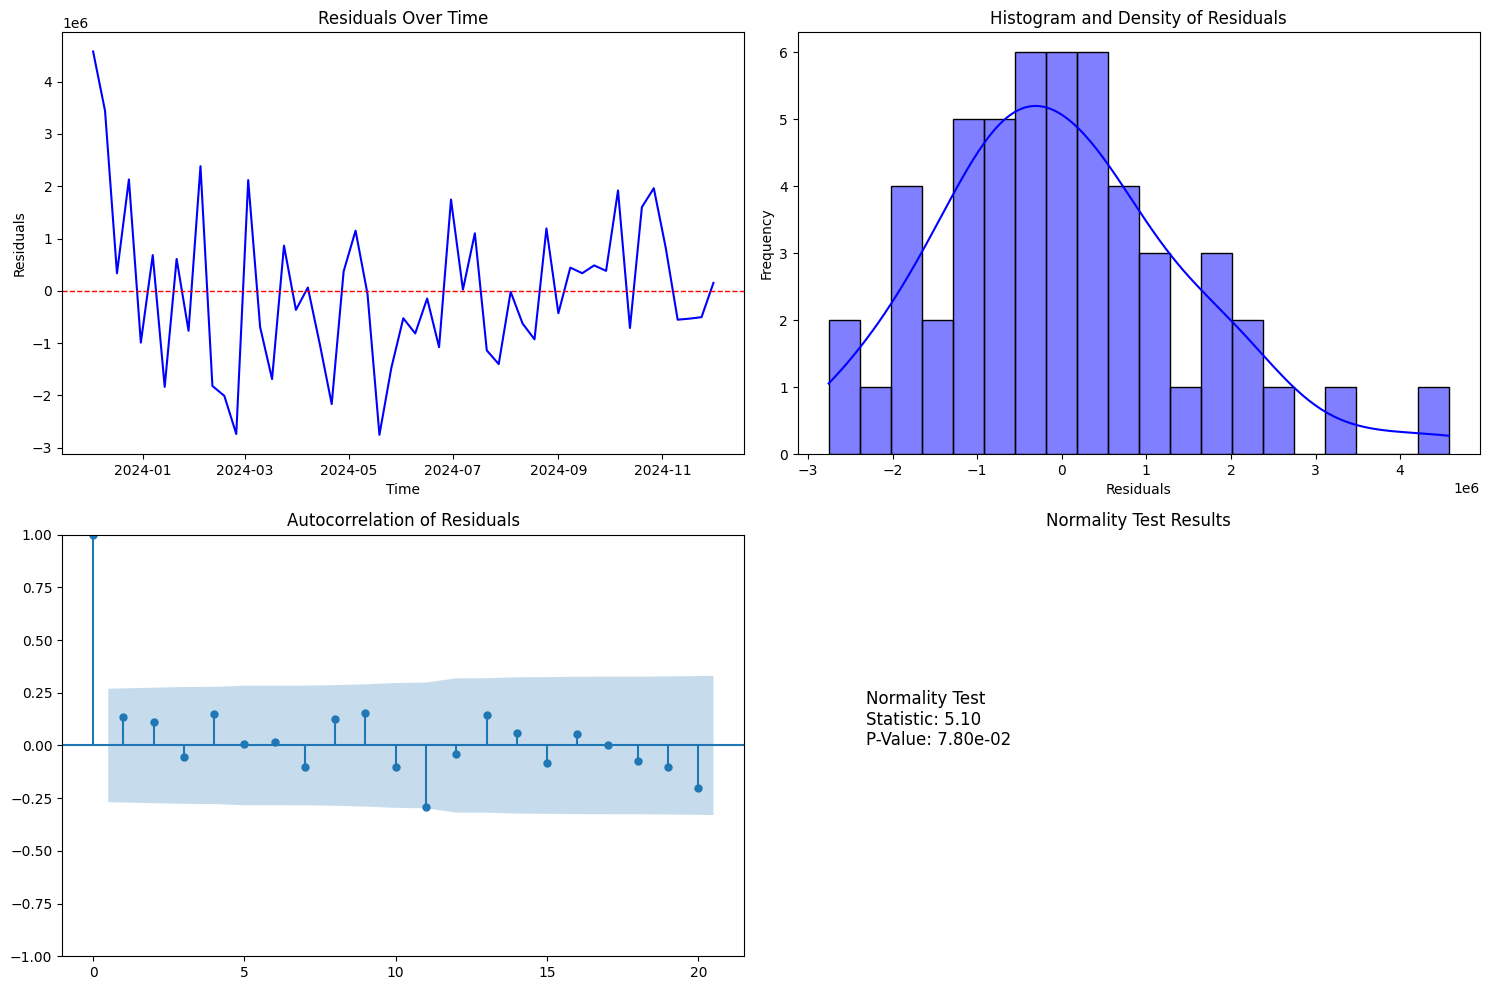

In [31]:
# Step 4: Combined Plot for Residual Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# A. Residual Time Series Plot
axes[0, 0].plot(residuals, color="blue")
axes[0, 0].axhline(y=0, color="red", linestyle="--", linewidth=1)
axes[0, 0].set_title("Residuals Over Time")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Residuals")

# B. Histogram and Density Plot (Normality Check)
sns.histplot(residuals, kde=True, bins=20, ax=axes[0, 1], color="blue", label="Residuals")
axes[0, 1].set_title("Histogram and Density of Residuals")
axes[0, 1].set_xlabel("Residuals")
axes[0, 1].set_ylabel("Frequency")

# C. ACF Plot (Autocorrelation of Residuals)
plot_acf(residuals, lags=20, ax=axes[1, 0])
axes[1, 0].set_title("Autocorrelation of Residuals")

# D. Residuals vs. Normal Distribution Test
normality_test = normaltest(residuals)
axes[1, 1].text(0.1, 0.5, f"Normality Test\nStatistic: {normality_test.statistic:.2f}\nP-Value: {normality_test.pvalue:.2e}", 
                fontsize=12, ha="left")
axes[1, 1].axis("off")
axes[1, 1].set_title("Normality Test Results")

# Adjust layout
plt.tight_layout()
plt.show()


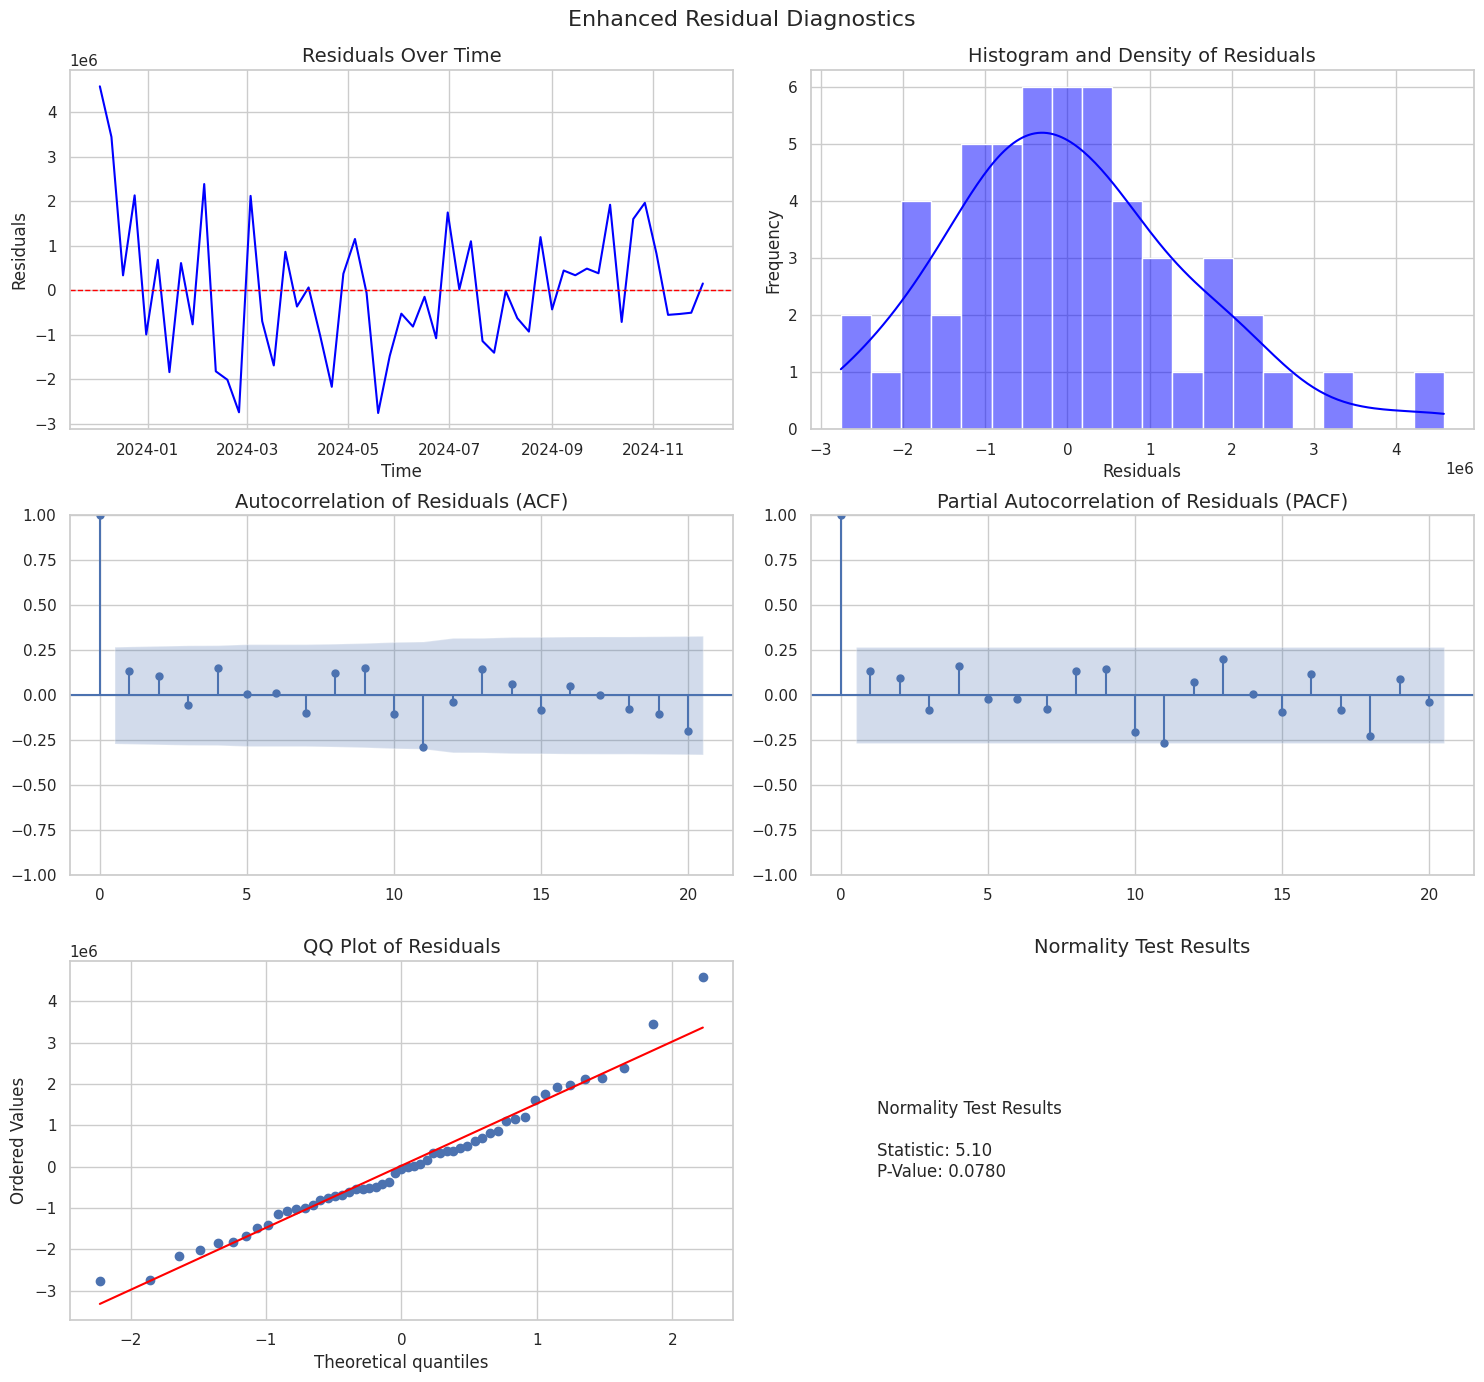

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from scipy.stats import normaltest, probplot

# Ensure Seaborn style is applied for improved visuals
sns.set_theme(style="whitegrid")

# Create subplots for enhanced residual diagnostics
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle("Enhanced Residual Diagnostics", fontsize=16, y=0.92)

# A. Residuals Over Time
axes[0, 0].plot(residuals, color="blue", linewidth=1.5)
axes[0, 0].axhline(y=0, color="red", linestyle="--", linewidth=1)
axes[0, 0].set_title("Residuals Over Time", fontsize=14)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Residuals")

# B. Histogram and Density Plot
sns.histplot(residuals, kde=True, bins=20, ax=axes[0, 1], color="blue")
axes[0, 1].set_title("Histogram and Density of Residuals", fontsize=14)
axes[0, 1].set_xlabel("Residuals")
axes[0, 1].set_ylabel("Frequency")

# C. Autocorrelation (ACF) Plot
plot_acf(residuals, lags=20, ax=axes[1, 0])
axes[1, 0].set_title("Autocorrelation of Residuals (ACF)", fontsize=14)

# D. Partial Autocorrelation (PACF) Plot
plot_pacf(residuals, lags=20, ax=axes[1, 1])
axes[1, 1].set_title("Partial Autocorrelation of Residuals (PACF)", fontsize=14)

# E. QQ Plot (Quantile-Quantile Plot)
probplot(residuals, dist="norm", plot=axes[2, 0])
axes[2, 0].get_lines()[1].set_color("red")  # Line of best fit
axes[2, 0].set_title("QQ Plot of Residuals", fontsize=14)

# F. Normality Test Results
normality_test = normaltest(residuals)
axes[2, 1].text(
    0.1, 0.5,
    f"Normality Test Results\n\nStatistic: {normality_test.statistic:.2f}\nP-Value: {normality_test.pvalue:.4f}",
    fontsize=12, ha="left", va="center"
)
axes[2, 1].axis("off")
axes[2, 1].set_title("Normality Test Results", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Leave space for the main title
plt.show()


## Explanation of Residual Diagnostic Plots:

### For Statisticians and Data Scientists

##### Residuals Over Time (Top-Left):

This plot shows how residuals (errors) vary across time.

Interpretation:
The red dashed line represents zero error. Residuals should ideally fluctuate randomly around this line.
Any patterns or trends (e.g., increasing residuals) suggest that the model might be missing some time-dependent features or seasonal patterns.
In this case, the residuals appear mostly centered around zero, but there are some fluctuations that might indicate minor issues.

##### Histogram and Density Plot of Residuals (Top-Right):

This plot assesses the distribution of residuals.

Interpretation:
A bell-shaped histogram with a superimposed density curve suggests normally distributed residuals, which is an assumption of many models.
Here, the histogram shows some deviation from normality, particularly on the right tail, but it is reasonably close.

##### Autocorrelation of Residuals (ACF, Bottom-Left):
This plot shows the correlation of residuals at different lags.

Interpretation:

If residuals are independent, the autocorrelation should be within the blue confidence intervals.

Significant spikes (like at lag 1) indicate residual autocorrelation, suggesting the model may not have fully captured temporal dependencies.

##### Partial Autocorrelation of Residuals (PACF, Bottom-Right):

This plot shows the direct correlation of residuals at specific lags, removing the influence of intermediate lags.

Interpretation:
Similar to ACF, significant spikes suggest the model may require additional AR (autoregressive) terms or adjustments.

##### QQ Plot (Bottom-Left in Second Diagram):
This compares the quantiles of residuals to a normal distribution.

Interpretation:
Points falling along the red line indicate normality.
Deviations in the tails (e.g., residuals on the far right) suggest heavy-tailed distributions or outliers.

##### Normality Test Results (Bottom-Right in Second Diagram):

Statistic and P-value:
A p-value > 0.05 suggests the residuals are not significantly different from a normal distribution.
In this case, a p-value of 0.078 suggests weak evidence against normality, meaning residuals are close to normal.

### For Business Decision Makers

##### Residuals Over Time:

This plot shows whether the model is making consistent errors over time.
Key Insight:
Random scatter around zero indicates the model's predictions are unbiased over time.
If you see patterns, the model might miss capturing key trends or seasonality in the data.

##### Histogram and Density:

This plot shows how often the model over- or under-predicts.
Key Insight:

A balanced distribution means the model is equally likely to over- or under-predict.
If the histogram skews significantly, the model might systematically overestimate or underestimate.

##### Autocorrelation (ACF):

This tells whether model errors are related over time.
Key Insight:
Low autocorrelation (small spikes) means the model's predictions are independent of past errors, which is ideal for forecasting.

##### QQ Plot and Normality Test:

These evaluate the model's assumptions about error distributions.
Key Insight:
Near-normal residuals indicate a robust model that is likely reliable for making predictions.

#### Overall Model Evaluation
Strengths:

Residuals are relatively centered around zero, indicating an unbiased model.
The normality test suggests residuals are close to normal, supporting reliable inference.
Weaknesses:

Some minor autocorrelation in residuals, suggesting that the model may miss some temporal dependencies.
Slight deviations from normality in the residual distribution, especially in the tails.

Next Steps:

Consider refining the model by adding additional seasonal components or external factors.
Explore more advanced models (e.g., SARIMAX with additional explanatory variables or machine learning approaches) if needed for higher accuracy.
This analysis provides confidence that the current model performs reasonably well but might need fine-tuning for long-term predictions.

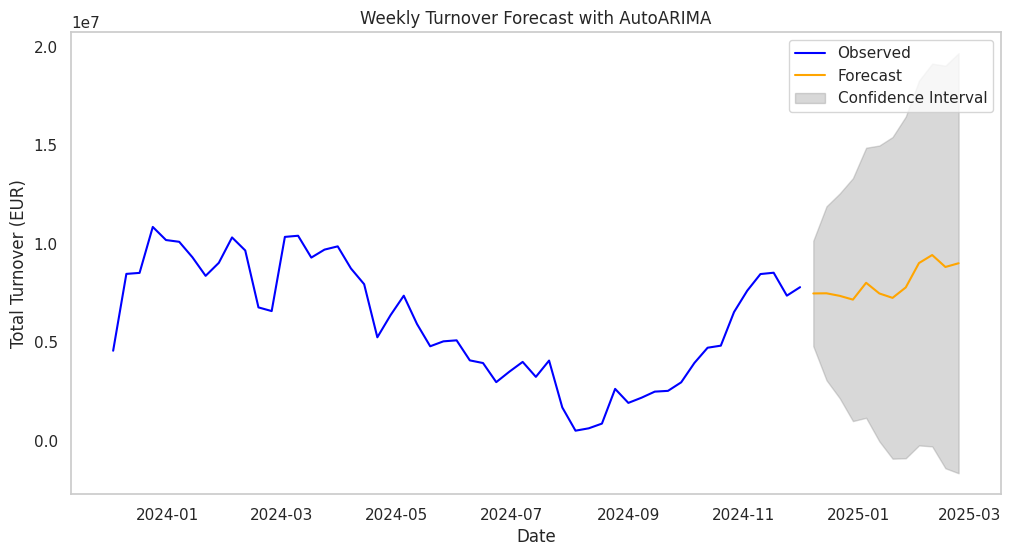

                Forecast   Lower Bound   Upper Bound
2024-12-08  7.482558e+06  4.809480e+06  1.015564e+07
2024-12-15  7.490157e+06  3.079461e+06  1.190085e+07
2024-12-22  7.360921e+06  2.169256e+06  1.255259e+07
2024-12-29  7.169595e+06  1.009453e+06  1.332974e+07
2025-01-05  8.023033e+06  1.174356e+06  1.487171e+07
2025-01-12  7.482205e+06 -1.901877e+04  1.498343e+07
2025-01-19  7.258472e+06 -8.972101e+05  1.541415e+07
2025-01-26  7.787404e+06 -8.762028e+05  1.645101e+07
2025-02-02  9.023083e+06 -2.252762e+05  1.827144e+07
2025-02-09  9.430779e+06 -2.741452e+05  1.913570e+07
2025-02-16  8.825250e+06 -1.383387e+06  1.903389e+07
2025-02-23  9.013983e+06 -1.636665e+06  1.966463e+07


In [33]:
# Step 6: Forecast Future Weekly Turnover
forecast_steps = 12  # Forecast next 12 weeks
forecast, conf_int = auto_arima_model.predict(n_periods=forecast_steps, return_conf_int=True)

# Create forecast index
forecast_index = pd.date_range(data_weekly.index[-1] + pd.Timedelta(days=7), periods=forecast_steps, freq="W")

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(data_weekly, label="Observed", color="blue")
plt.plot(forecast_index, forecast, label="Forecast", color="orange")
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color="gray", alpha=0.3, label="Confidence Interval")
plt.title("Weekly Turnover Forecast with AutoARIMA")
plt.xlabel("Date")
plt.ylabel("Total Turnover (EUR)")
plt.legend()
plt.grid()
plt.show()

# Step 7: Forecast DataFrame
forecast_df = pd.DataFrame({
    "Forecast": forecast,
    "Lower Bound": conf_int[:, 0],
    "Upper Bound": conf_int[:, 1]
}, index=forecast_index)

# Display forecast results
print(forecast_df)

## Explanation for Data Scientists and Statisticians

### Code Overview
Forecast Generation:

The auto_arima_model.predict() method generates forecasts for the next 12 weeks (n_periods=12).
Confidence intervals are calculated alongside the forecast by setting return_conf_int=True.
Forecast Index Creation:

The forecast index begins one week after the last observed data point and extends for 12 periods with weekly frequency (freq="W").
Forecast Visualization:

Observed historical data (data_weekly) is plotted in blue to represent the actual turnover values.
Forecasted turnover is plotted in orange, showing the predicted values for future weeks.
Confidence intervals are represented by a gray shaded region, capturing the uncertainty of the forecast.

Forecast DataFrame:

A DataFrame is created containing forecasted values, lower bounds, and upper bounds for structured analysis and reporting.

### Graph Description

The blue line represents historical weekly turnover data.

The orange line indicates forecasted turnover values for the next 12 weeks.

The gray shaded region represents the confidence interval, which covers 95% of the expected future turnover values.

#### Statistical Insights

The ARIMA model parameters are optimized using the auto_arima function, ensuring a well-fitted model.
Confidence intervals provide a measure of the uncertainty in predictions, reflecting the reliability of the model.
Observed trends and seasonality in the data are incorporated into the forecast, making it suitable for turnover projection.

#### Explanation for Business Decision Makers

*Graph Description:*

Historical turnover data is visualized as a blue line, highlighting past trends and patterns.
Forecasted turnover for the next 12 weeks is represented by the orange line, providing a projection of future performance.
The gray shaded region, known as the confidence interval, captures the range where future turnover is expected to fall with 95% certainty. Wider intervals indicate higher uncertainty in predictions.

*Business Applications*

Revenue Planning:

The orange forecast line can guide weekly revenue targets.
The gray confidence intervals can be used to prepare for optimistic and pessimistic scenarios.

*Risk Mitigation:*

A significant drop in the lower bound of the confidence interval can signal potential risks, requiring contingency planning.

*Strategic Decision-Making:*

Trends in the orange forecast line, such as increases or decreases, can inform decisions on marketing, operational adjustments, or investment strategies.

#### Key Takeaways

The forecast model accounts for seasonality and historical patterns, making it a reliable tool for weekly turnover predictions.
Confidence intervals highlight uncertainty, aiding in scenario planning.

Insights derived from the model can inform operational, financial, and strategic decisions.